# Learning parameter visulaizer


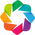

In [1]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import, unicode_literals
import glob
import os 
import shutil
import numpy as np
import pandas as pd
from operator import mul, add
from matplotlib import pyplot as plt
import IPython
import holoviews as hv

# coding: utf-8
import pydot
from IPython.display import display
import IPython.display
import pydotplus
hv.extension('bokeh')
%matplotlib inline

### 言語モジュール

In [2]:
import numpy as np
import pickle
import glob

def load_model(model_path):
    with open(model_path, "rb" ) as f:
        a, b = pickle.load( f )
    return a, b

遷移確率と出力確率を計算  
パラメータ：α、β

In [3]:
#パラメータ
###############################################
numOfAllConc = 6        #助詞を含んだ概念クラスの数
numOfConc = 3           #助詞を除いた概念クラスの数
################################################
ALPHA_WORD = 10.0
NUM_OF_CONC = numOfConc
NUM_OF_TAGS = numOfAllConc
NUM_OF_ALL_TAGS = NUM_OF_TAGS + 2
ALPHA_TAG  = 0.1 * 1.0 / (NUM_OF_ALL_TAGS)
def LoadAndCalcHMMParams(Nyy, Nyx):

    # 文頭・文末を含んだ状態数
    numOfAllPossibleStates = Nyy.shape[0]

    # 文頭・文末を含まない状態数
    numOfStates = numOfAllPossibleStates - 2

    # 辞書内の単語数
    numOfWords = Nyx.shape[1]

    """
    # 初期遷移確率を文頭・文末以外の状態で均等
    initProb = [0.0] * numOfAllPossibleStates
    for i in range(1, numOfStates+1):
        initProb[i] = 1.0/numOfStates
    """

    # 遷移・出力確率の計算
    transitionProb = np.zeros( Nyy.shape )
    emissionProb   = np.zeros( Nyx.shape )

    # 遷移確率
    for i in range(numOfAllPossibleStates-1):
        sum_i = sum(Nyy[i, :]) + NUM_OF_TAGS * ALPHA_TAG
        for j in range(1, numOfAllPossibleStates):
            transitionProb[i, j] = (Nyy[i, j] + ALPHA_TAG) / sum_i

    # 出力確率
    for i in range(1, numOfAllPossibleStates):
        #sum_i = sum(Nyx[i, :]) + numOfWords * ALPHA_WORD
        sum_i = sum(Nyx[i, :]) + ALPHA_WORD
        for j in range(numOfWords):
            emissionProb[i, j] = (Nyx[i, j] + ALPHA_WORD*(1.0/numOfWords)) / sum_i
            #emissionProb[i, j] = (Nyx[i, j] + ALPHA_WORD) / sum_i

    #return initProb, transitionProb, emissionProb
    return transitionProb, emissionProb

In [4]:
index_name = []
index_name.append("start")
index_name.extend(["concept_{0}".format(i) for i in range(numOfConc)] )
index_name.extend( ["particles_{0}".format(i) for i in range(numOfAllConc - numOfConc)] )
index_name.append("stop")

### 遷移確率の可視化

In [5]:
def markovViz(df, fileName='default'):
     
    #オブジェクトを定義
    graph = pydotplus.Dot(graph_type='digraph')
    
    #ノードを追加
    for c in df.columns:
        node = pydotplus.Node(c)
        node.set_name(c) # 日本語の読み込みが可能なように名前を定義し直す
#         node.set_fontsize(60)
        graph.add_node(node)
     
    #エッジを追加    
    for i in df.index:
        for c in df.columns:
            if df.ix[i, c] > 0:
                edge = pydotplus.Edge(graph.get_node(i)[0], graph.get_node(c)[0])
                edge.set_label('{:.2f}'.format(df.ix[i, c]))
#                 edge.set_fontsize(30)
                graph.add_edge(edge)

 
    #グラフ描画 
    graph.write_png(fileName + ".png", prog='dot')
    graph.write_svg(fileName + ".svg", prog='dot')

In [6]:
Nyy, Nyx = load_model("../src/module011_hmm_language/model_004.pickle")
transitionProb, emissionProb = LoadAndCalcHMMParams(Nyy, Nyx)

df = pd.DataFrame(index=index_name,
                  columns=index_name, 
                  data=transitionProb)
df[df < 0.1] = 0

/home/miyazawa/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


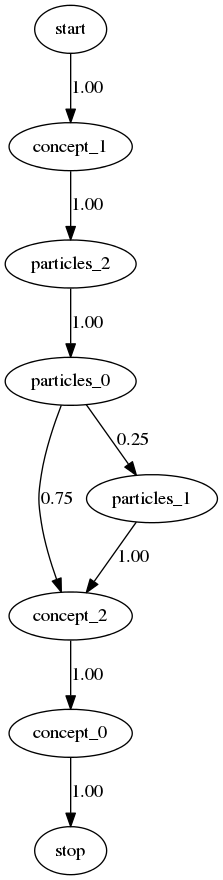

In [7]:
# coding: utf-8
markovViz(df)
IPython.display.Image("default.png")

### 各品詞の出力確率

In [8]:
word_list_df = pd.read_csv('../src/codebook.txt',header=-1)
wordlist = []
for i in range(len(word_list_df)):
    wordlist.append(word_list_df.iloc[i][0])

In [26]:
def bhmm_graph(head_num):
    Nyy, Nyx = load_model("../src/module011_hmm_language/model_004.pickle")
    transitionProb, emissionProb = LoadAndCalcHMMParams(Nyy, Nyx)

    emission_df = pd.DataFrame(emissionProb).T
    word_list_df = pd.DataFrame(wordlist)
    tmp_df = pd.concat([word_list_df,emission_df],axis=1)
    tmp_df_columns = ["word"]
    tmp_df_columns.extend(index_name)
    tmp_df.columns = tmp_df_columns

    graph = []
    tmp_list = []
    tmp_list.extend(["concept_{0}".format(i) for i in range(numOfConc)] )
    tmp_list.extend( ["particles_{0}".format(i) for i in range(numOfAllConc - numOfConc)] )
    for idx in tmp_list:
        data = tmp_df.sort_values(by=idx,ascending=False).head(head_num)[['word',idx]]
        data = data.fillna("@@@".encode("utf-8"))
        data.columuns = [['word','prob']]
        graph.append(hv.Bars(data,label=idx).redim.range(prob=(0,1.0)))
    return reduce(add,graph).cols(2)

In [27]:
hv.extension('matplotlib')

:Layout
   .Bars.Concept_0   :Bars   [word]   (concept_0)
   .Bars.Concept_1   :Bars   [word]   (concept_1)
   .Bars.Concept_2   :Bars   [word]   (concept_2)
   .Bars.Particles_0 :Bars   [word]   (particles_0)
   .Bars.Particles_1 :Bars   [word]   (particles_1)
   .Bars.Particles_2 :Bars   [word]   (particles_2)
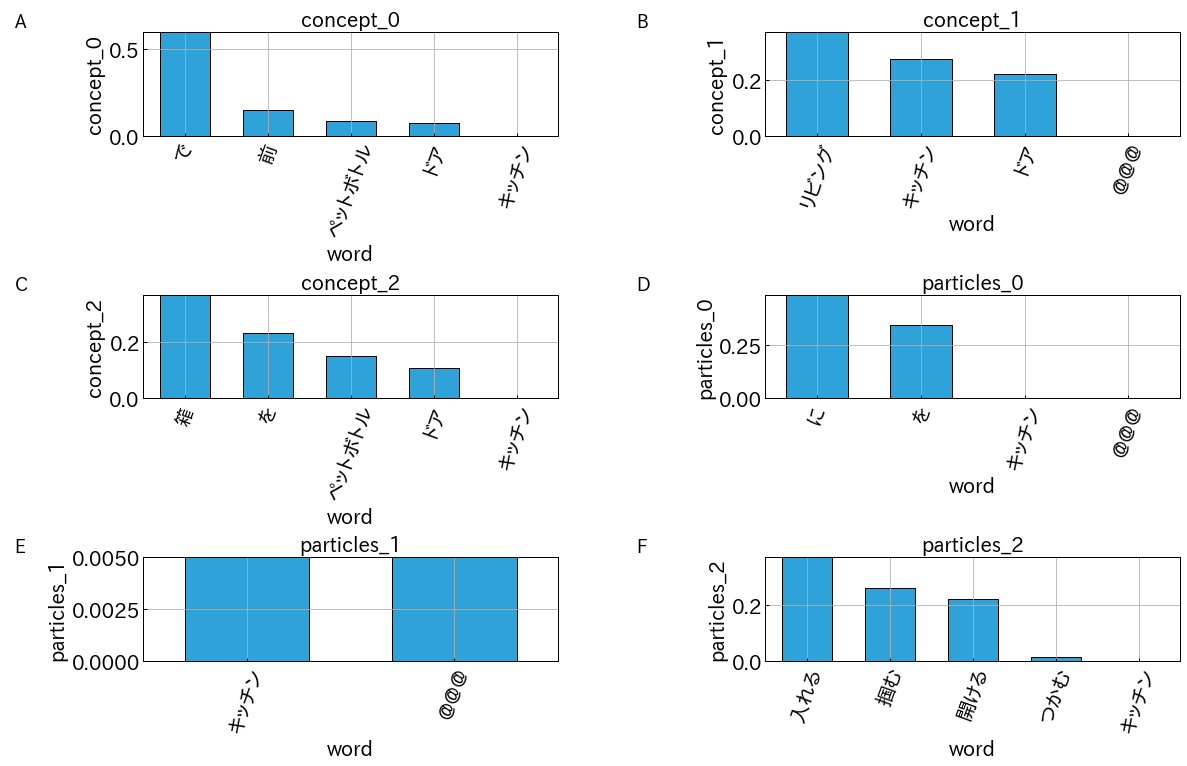

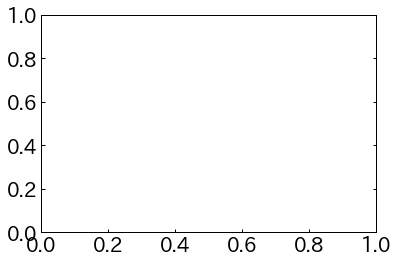

In [29]:
%%output size=200
%%opts Bars [aspect=4 fontsize=20 xrotation=70 show_frame=True show_grid=True] (cmap='Reds' align="edge")
dict_spec ={
        "Bars":{
                'style':dict(cmap='Reds', align="edge"),
                'plot':dict(aspect=4,fontsize=20, xrotation=70, show_frame=True, show_grid=True),
                }
        }

plt.rcParams['font.family'] = 'IPAPGothic'

# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 20 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ

# plt.figure(figsize=(3.14,20.28)) #3.14 インチは約8cm。
plt.gca().yaxis.set_tick_params(which='both', direction='in',bottom=True, top=True, left=True, right=True)

a = bhmm_graph(5).opts(dict_spec)

# hv.renderer('matplotlib').instance(fig='pdf').save(a, './out', )
# hv.renderer('matplotlib').instance(fig='svg').save(a, './out', )
a

### 遷移確率と出力確率を合わせた可視化

In [20]:
def trans_outViz(threshold, threshold_word, fileName='default.png'):
    word_list_df = pd.read_csv('../src/codebook.txt',header=-1)
    wordlist = []
    for i in range(len(word_list_df)):
        wordlist.append(word_list_df.iloc[i][0])

    Nyy, Nyx = load_model("../src/module011_hmm_language/model_004.pickle")
    transitionProb, emissionProb = LoadAndCalcHMMParams(Nyy, Nyx)

    emission_df = pd.DataFrame(emissionProb).T
    word_list_df = pd.DataFrame(wordlist)
    tmp_df = pd.concat([word_list_df,emission_df],axis=1)
    tmp_df_columns = ["word"]
    tmp_df_columns.extend(index_name)
    tmp_df.columns = tmp_df_columns

    tmp_words = []
    tmp_list = []
    tmp_list.extend(["concept_{0}".format(i) for i in range(numOfConc)] )
    tmp_list.extend( ["particles_{0}".format(i) for i in range(numOfAllConc - numOfConc)] )
    for idx in tmp_list:
        data = tmp_df.sort_values(by=idx,ascending=False)[['word',idx]]
        data = data[data[idx] > threshold_word]
        tmp_words.append('\n'.join([w.decode("utf-8") for w in data.word.values]))

    index_word = []
    index_word.append("start")
    index_word.extend(tmp_words)
    index_word.append("stop")

    df = pd.DataFrame(index=index_word,
                      columns=index_word, 
                      data=transitionProb)
    df[df < threshold] = 0

    markovViz(df,fileName)

/home/miyazawa/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


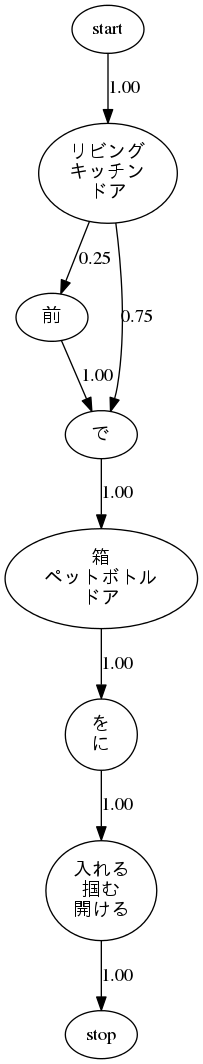

In [21]:
trans_outViz(0.05,0.05,"./trans_out")
IPython.display.Image("./trans_out.png")